###  Part I: Given model 1 and model 2, each was used to make predictions on a test set of 1,466 sequences. After making these predictions, we measured the prediction accuracy for each sequence. We aim to determine if the performance of model 1 and model 2 is statistically different.

In [98]:
import json
import numpy as np
from scipy.stats import ttest_rel, wilcoxon, shapiro
import matplotlib.pyplot as plt
import pandas as pd

In [99]:
def load_json(filepath):
    # Open and read the JSON file
    with open(filepath, 'r') as file:
        data = json.load(file)  # This converts the JSON file into a Python dictionary
    return data

Load prediction results: "accuracies_model_1" and "accuracies_model_2" contain the accuracies for each sequence in the test set, obtained by model 1 and model 2, respectively. The variable "seq_len" contains length for each sequence in the test set.

In [100]:
filename = './stat/SPOT-2016_encoding_results.json'
results = load_json(filename)
accuracies_model_1 = np.array(results['onehot']['SS3']['sequence_accuracies'])
accuracies_model_2 = np.array(results['morgan']['SS3']['sequence_accuracies'])
seq_len = np.array(results['onehot']['SS3']['lengths_excluding_padding'])

#### Normal Distribution test for the differences between paired
We use 3 different methods: Shapiro-Wilk Test, histogram, and Q-Q (quantile-quantile) plot.

In [101]:
# Calculate differences
differences = accuracies_model_1 - accuracies_model_2

# Check normality of the differences
stat, p_value = shapiro(differences)
print("Shapiro-Wilk Test: Stat=", stat, ", p-value=", p_value)

Shapiro-Wilk Test: Stat= 0.869839072227478 , p-value= 2.9100007339788756e-33


Since the p-value is less than 0.05 according to the Shapiro-Wilk test, the differences between the paired samples do not follow a normal distribution. Next, we will visualize the histogram of differences.

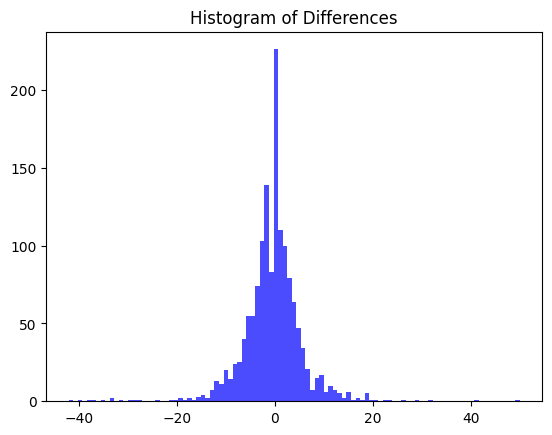

In [102]:
# Plot histogram
plt.hist(differences, bins='auto', alpha=0.7, color='blue')
plt.title('Histogram of Differences')
plt.show()

#### The histogram does not appear to be normally distributed
The histogram shows two peaks, which is a sign of bimodality. There is an apparent skewness to the right. The central peak appears to be quite sharp and taller than what one would expect in a normal distribution, suggesting a leptokurtic nature. Next, we will visualize the Q-Q plot.

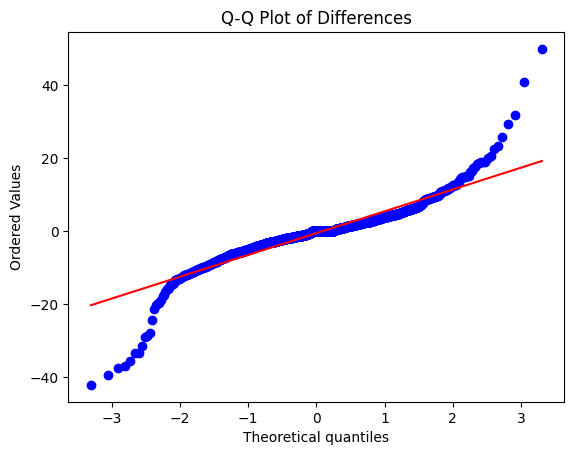

In [103]:
# Generate Q-Q plot
stats.probplot(differences, dist="norm", plot=plt)
plt.title('Q-Q Plot of Differences')
plt.show()

#### The Q-Q plot indicates a non-normal distribution
The S-shaped curve in the Q-Q plot indicates that the the distribution of differences between paired samples is heavy-tailed on both ends compared to a normal distribution. 

#### Choice of statistic test
With larger sample sizes, the Central Limit Theorem suggests that the mean of the sample distributions can approximate normality,
even if the underlying distribution is not normal. How large the sample size need to be depend on the skewness of the underlying distribution. We have 1466 sequences, so it might be safe to use paired-sample t-test in this case. But in this notebook, we will use non-parametric Wilcoxon signed-rank test. This test does not assume normality. It evaluates whether the median of the differences between two paired sets is zero. It is more robust against non-normal distributions and outliers.


In [104]:
def wilcoxon_test(acc_model_1, acc_model_2):
    stat, p_value = wilcoxon(acc_model_1, acc_model_2)

    print("Wilcoxon Test Statistic:", stat)
    print("P-value:", p_value)

    if p_value < 0.05:
        print("The difference in performance is statistically significant.")
    else:
        print("No significant difference in performance was detected.")
        
    return stat, p_value

stat, p_value = wilcoxon_test(accuracies_model_1, accuracies_model_2)

Wilcoxon Test Statistic: 364427.0
P-value: 0.0006866361175005193
The difference in performance is statistically significant.


### Part II: Linear Regression and Quantile Regression to model the dependence of performance differences between the two models on sequence length.

The bar chart below displays the distribution of sequence counts by accuracy difference intervals across various sequence length ranges.

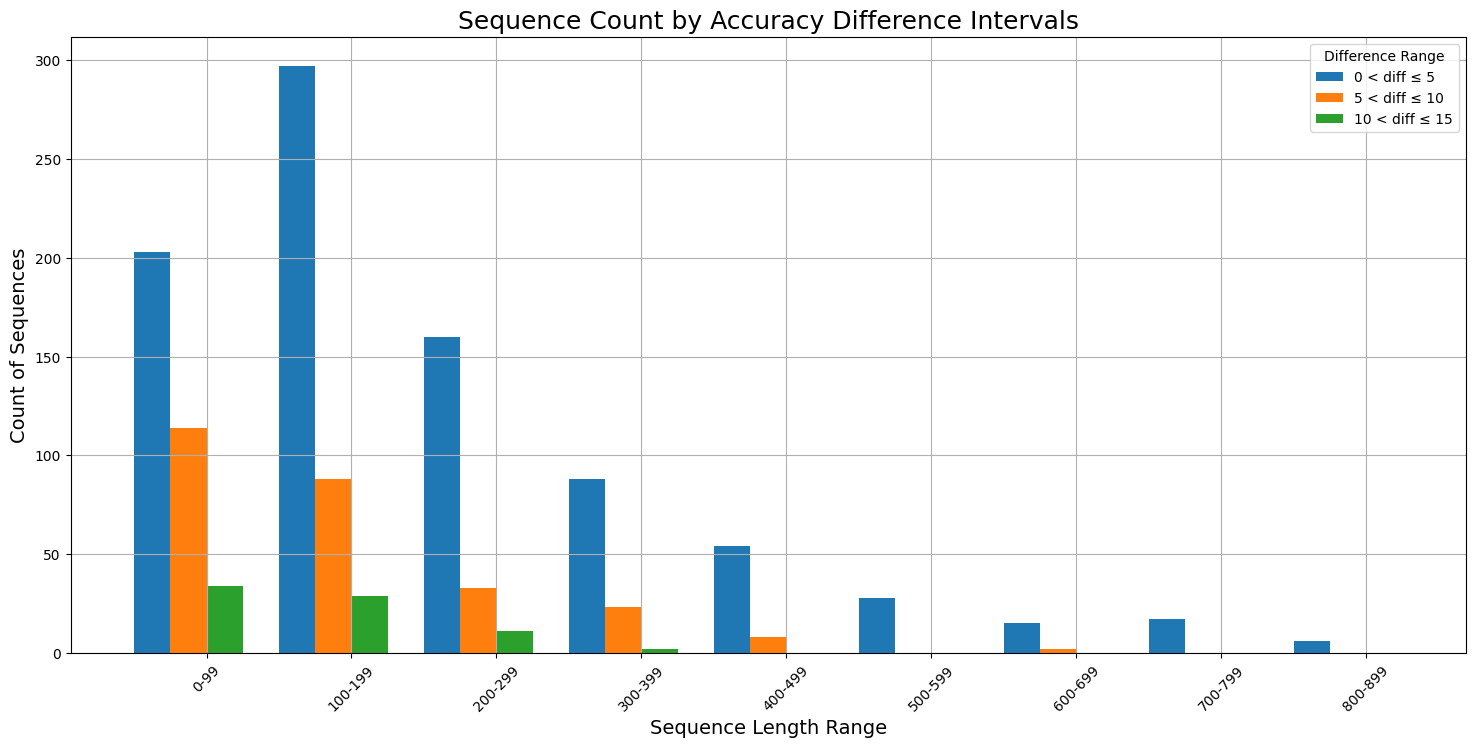

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    'seq_len': seq_len,
    'diff': abs(differences),
})

# Bin configuration
bin_edges = np.arange(0, 1000, 100)
labels = [f'{i}-{i+99}' for i in bin_edges[:-1]]
df['bin'] = pd.cut(df['seq_len'], bins=bin_edges, labels=labels, right=False)

# Define threshold ranges
threshold_ranges = [(0, 5), (5, 10), (10, 15)]
threshold_labels = ['0 < diff ≤ 5', '5 < diff ≤ 10', '10 < diff ≤ 15']

# Initialize plot data
plot_data = {label: np.zeros(len(labels)) for label in threshold_labels}

# Populate plot data
for i, (low, high) in enumerate(threshold_ranges):
    label = threshold_labels[i]
    mask = (df['diff'] > low) & (df['diff'] <= high)
    counts = df[mask].groupby('bin').size()
    for idx, count in counts.iteritems():
        if idx in labels:
            plot_data[label][labels.index(idx)] = count

# Plotting
fig, ax = plt.subplots(figsize=(18, 8))
width = 0.25  # Bar width

x = np.arange(len(labels))  # Label locations for the bins
offset = width * len(threshold_ranges) / 2  # Center bars around labels

for i, label in enumerate(threshold_labels):
    bar_position = x + i * width - offset
    ax.bar(bar_position, plot_data[label], width, label=label)

# Customize the plot
ax.set_xlabel('Sequence Length Range', fontsize=14)
ax.set_ylabel('Count of Sequences', fontsize=14)
ax.set_title('Sequence Count by Accuracy Difference Intervals',fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title="Difference Range")

plt.grid(True)
plt.show()


The chart shows a general decrease in sequence count as sequence length increases, which is typical due to the reduced frequency of longer sequences in many biological datasets. For shorter sequences (e.g., 0-99, 100-199), there is a higher count of sequences across all difference ranges, indicating that the two compared models perform most differently for shorter sequences.

#### Linear Regression
From visualization, we anticipate thath there might be a linear relationship between model accuracy differrence and sequence length. 

In the following, we will model the linear relationship using linear regression.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


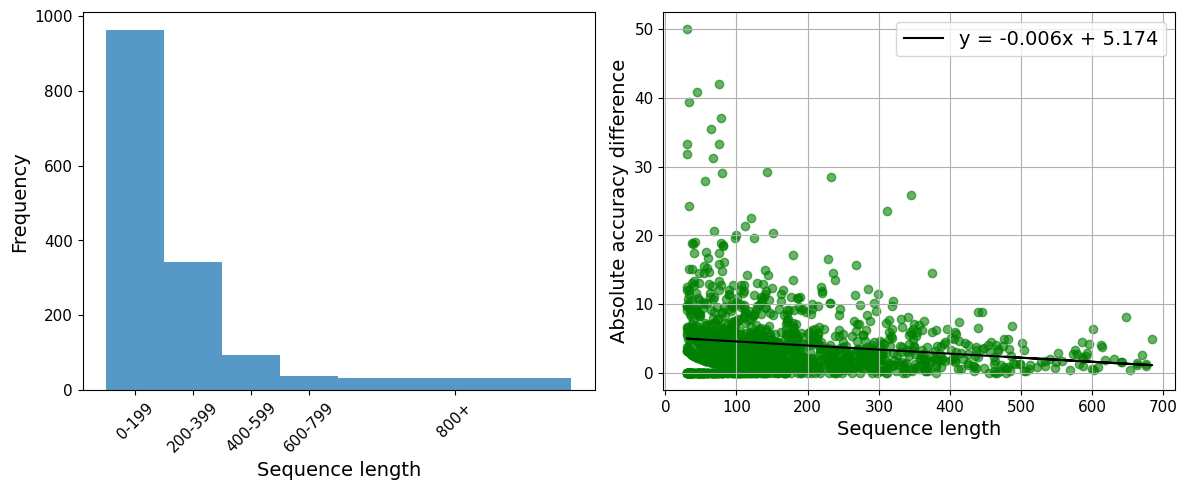

In [106]:
mask = seq_len <= 700
filtered_seq_len = df['seq_len'][mask]
filtered_differences = df['diff'][mask]

# Define bins and labels for the histogram
bin_edges = [0, 199, 399, 599, 799, 1600]  # Adjust maximum to match filter
bin_labels = ['0-199', '200-399', '400-599', '600-799', '800+']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjust size as needed

# Plotting the histogram on the left subplot
axs[0].hist(seq_len, bins=bin_edges, alpha=0.75)
axs[0].set_xlabel('Sequence length', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
#axs[0].set_title('Distribution of Sequence Lengths', fontsize=16)
#axs[0].set_xticks(bin_edges)  # Setting x-ticks at bin edges
axs[0].set_xticks([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])  # Midpoints of bins
axs[0].set_xticklabels(bin_labels, rotation=45, fontsize=13)
# Plotting the scatter plot and regression line on the right subplot
axs[1].scatter(filtered_seq_len, filtered_differences, alpha=0.6, color='green')
slope, intercept = np.polyfit(filtered_seq_len, filtered_differences, 1)  # Fit line
axs[1].plot(filtered_seq_len, slope*filtered_seq_len + intercept, 'black', label=f'y = {slope:.3f}x + {intercept:.3f}')  # Plot line
#axs[1].set_title('Absolute Accuracy Difference vs. Sequence Length', fontsize=13)
axs[1].set_xlabel('Sequence length', fontsize=14)
#axs[1].set_xticklabels(diff_oh_mg,fontsize=13)  # Midpoints of bins
axs[1].set_ylabel('Absolute accuracy difference', fontsize=14)

axs[1].legend(fontsize=14)
axs[1].grid(True)
axs[1].tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='x', labelsize=11)

axs[0].tick_params(axis='y', labelsize=11)
axs[0].tick_params(axis='x', labelsize=11)

# Adjust layout to prevent overlap and ensure clear visibility
plt.tight_layout()

plt.savefig('linear_reg.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

The histogram on the left shows the distribution of sequence lengths.
We can see that most sequences in our data are shorter, confirming our analysis from 
the previous session. Due to the sparse representation of sequences longer than 700,
we limited the linear regression fit to sequences shorter than 700. 

Next, we will analyze the detailed results of ordinary least squares fitting.

In [107]:
import numpy as np
import statsmodels.api as sm

# Adding a constant to the predictor for an intercept in the model
X = sm.add_constant(filtered_seq_len)  # Predictor
y = filtered_differences  # Response variable

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     36.27
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           2.18e-09
Time:                        21:33:02   Log-Likelihood:                -4256.0
No. Observations:                1415   AIC:                             8516.
Df Residuals:                    1413   BIC:                             8526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1736      0.216     23.919      0.0

#### The relationship between sequence length and performance differences, while present, does not strongly influence the outcomes. The non-normality of the residuals suggests that linear regression may not be the best model for this data.

R-squared: 0.025 - This indicates that only 2.5% of the variance in the performance difference is explained by the model. 
F-statistic: 36.27 with a Prob (F-statistic) of 2.18e-09 - This tells us that the model is statistically significant, meaning the observed relationship between sequence length and performance difference is unlikely to be due to chance. Skew: 3.306 - This value indicates a high positive skew in the residuals. Kurtosis: 20.693 - This extremely high kurtosis indicates that the tails of the residual distribution are heavier than those of a normal distribution, pointing to the presence of outliers.


#### Quantile regression
we conducted a quantile linear regression, which does not re-
quire normally distributed residuals. This method allows for modeling various quantiles, such as the median or
the 25th and 75th percentiles, offering a comprehensive view of how sequence length
affects accuracy differences across the distribution.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


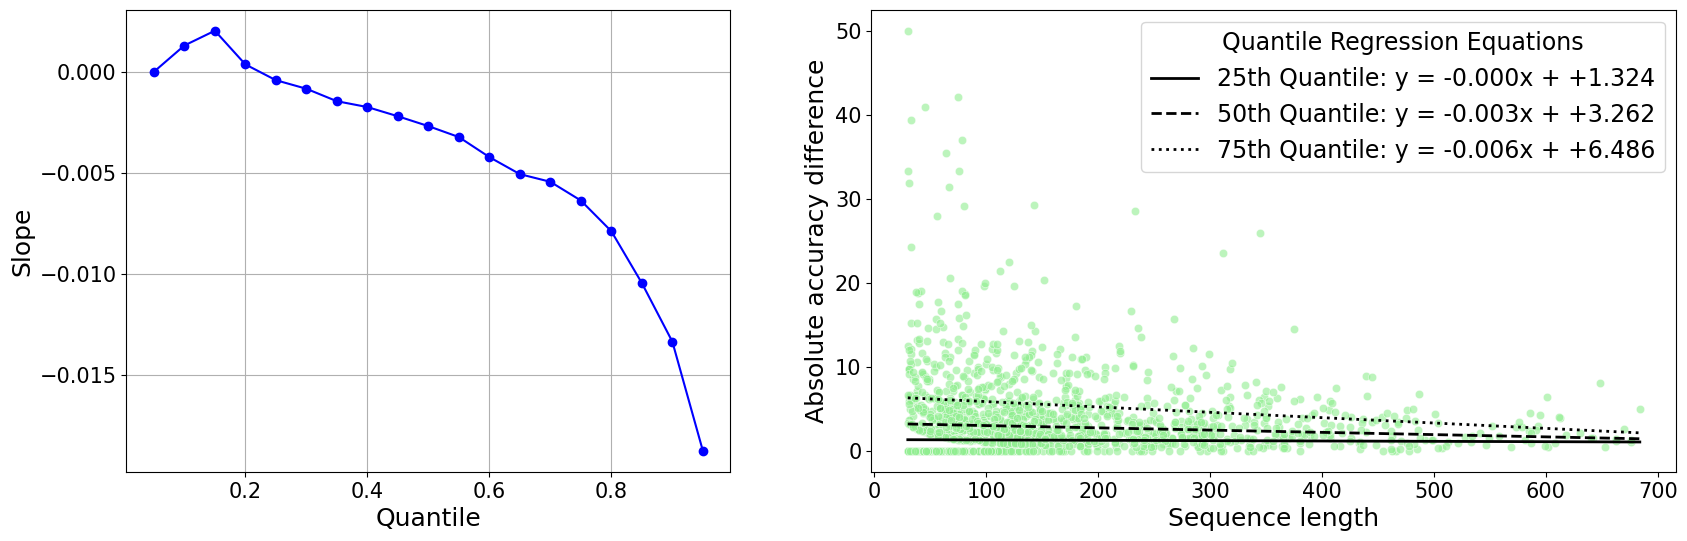

In [108]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Generate or load your DataFrame here with 'seq_len' and 'diff_oh_mg'
df = pd.DataFrame({
    'seq_len': filtered_seq_len,  # Sequence length: normal distribution
    'diff_oh_mg': filtered_differences  # Simulated data
})



# Fitting models at selected quantiles for the first plot
quantiles_range = np.arange(0.05, 1, 0.05)
results_range = []

for qt in quantiles_range:
    model = smf.quantreg('diff_oh_mg ~ seq_len', df).fit(q=qt)
    results_range.append([qt, model.params['Intercept'], model.params['seq_len']])

result_df_range = pd.DataFrame(results_range, columns=['quantile', 'Intercept', 'seq_len_coef'])

# Fitting models at selected quantiles for the second plot
quantiles_fixed = [0.25, 0.5, 0.75]
models_fixed = {qt: smf.quantreg('diff_oh_mg ~ seq_len', df).fit(q=qt) for qt in quantiles_fixed}

# Setting up the plot area: 1 row, 2 columns with width ratios
fig, ax = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1.5, 2]})

# First plot
ax[0].plot(result_df_range['quantile'], result_df_range['seq_len_coef'], marker='o', linestyle='-', color='b')
#ax[0].set_title('Coefficient of Sequence Length Across Quantiles')
ax[0].set_xlabel('Quantile', fontsize=18)
ax[0].set_ylabel('Slope', fontsize=18)
ax[0].grid(True)
ax[0].tick_params(axis='both', labelsize=14)  # Larger tick labels

# Second plot
sns.scatterplot(x='seq_len', y='diff_oh_mg', data=df, color='lightgreen', alpha=0.6, ax=ax[1])

line_styles = ['-', '--', ':']

# Generating and plotting lines for each quantile
for (qt, model), ls in zip(models_fixed.items(), line_styles):
    x_range = np.linspace(df['seq_len'].min(), df['seq_len'].max(), 30)
    y_pred = model.params['Intercept'] + model.params['seq_len'] * x_range
    ax[1].plot(x_range, y_pred, 
               label=f'{qt * 100:.0f}th Quantile: y = {model.params["seq_len"]:+.3f}x + {model.params["Intercept"]:+.3f}',
               linestyle=ls, color='black', linewidth=2)


#ax[1].legend(title="Quantile regression equations", fontsize='large', title_fontsize='large')
#ax[1].set_title('Quantile Regression Lines at Different Quantiles')
ax[1].set_xlabel('Sequence length', fontsize=18)
ax[1].set_ylabel('Absolute accuracy difference', fontsize=18)
ax[1].tick_params(axis='both', labelsize=15)  # Larger tick labels
ax[0].tick_params(axis='both', labelsize=15)  # Larger tick labels
ax[1].legend(title="Quantile Regression Equations", fontsize=17, title_fontsize=17)
plt.savefig('quantile_reg.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

As the quantile increases, the coefficient of sequence length
becomes more negative. At lower quantiles, the effect of sequence length on accu-
racy difference is negligible, suggesting limited influence at smaller absolute accuracy
differences. Conversely, the coefficients are increasingly negative at higher quantiles,
particularly beyond the median. This highlights a strong, negative impact of increas-
ing sequence length on larger initial differences.